### Import all necessary files

In [12]:
import pandas as pd
from tweets import *

### Get vectors from table of tweets

In [13]:
# tweets = read_all_tweets(DATA)
tweets, class_vector = read_n_tweets_from_data(DATA, 60)
tweet_vector = np.array(get_vectors(tweets))

### Find out epsilon
Find out epsilon by looking at distribution of max, min, median euclidean distances between all points.

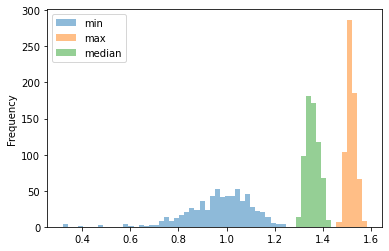

In [14]:
distances = create_and_save_distances_list(tweet_vector, save=False) # Compute distances
# distances = read_distances_list() # Read previously computed distances
minimum, median, maximum = get_basic_statistics(distances)
plot_basic_statistics(minimum, median, maximum)

### Group vectors for multiple epsilon
Now after analyzing distribution of distances between points
do clustering n times for epsilon_start and delta_epsilon parameters

In [15]:
%%time
n = 10
epsilon_start = 0.35
epsilon_end = 1.9
# clustering = sklearn.cluster.dbscan(X=tweet_vector, eps=1.1, min_samples=2)
# print(clustering)

results = get_results_for_multiple_eps(tweet_vector, epsilon_start, epsilon_end, n)

CPU times: user 21min, sys: 107 ms, total: 21min
Wall time: 21min 3s


### Results

Create dataframe from results to visualise it

In [16]:
%%time
df = pd.DataFrame()

for el_index, result in enumerate(results):
    current_epsi = epsilon_start + el_index * (epsilon_end-epsilon_start)/n
    for num in range(len(DATA)):
        cluster = []
        first_occ = class_vector.index(DATA[num])
        last_occ = next(i for i in reversed(range(len(class_vector))) if class_vector[i] == DATA[num])
        for point in result[first_occ:last_occ]:
            cluster.append(int(point.label))
        name = 'eps_' + str(current_epsi) + '_' + DATA[num]
        tmp_df = pd.DataFrame({name:cluster})
        df = pd.concat([df,tmp_df], ignore_index=False, axis=1)


CPU times: user 362 ms, sys: 1 ms, total: 363 ms
Wall time: 361 ms


### Visualisation

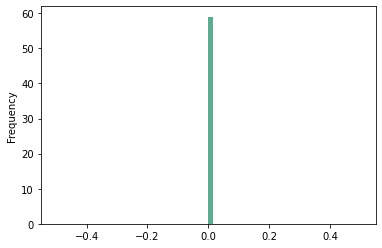

In [17]:
ax = df.plot.hist(bins=60, alpha=0.5, legend=False)
ax.plot()
plt.show()